In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

tsa_claims.csv



In [2]:
# Let's look at the data first
data = pd.read_csv('../input/tsa_claims.csv')
print("Number of samples in the data  : ", data.shape[0])
print("Columns in the dataset  : ", list(data.columns))
print(" ")
data.head()

Number of samples in the data  :  204267
Columns in the dataset  :  ['Claim Number', 'Date Received', 'Incident Date', 'Airport Code', 'Airport Name', 'Airline Name', 'Claim Type', 'Claim Site', 'Item', 'Claim Amount', 'Status', 'Close Amount', 'Disposition']
 


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


In [3]:
# Let's have an overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204267 entries, 0 to 204266
Data columns (total 13 columns):
Claim Number     204267 non-null object
Date Received    204004 non-null object
Incident Date    202084 non-null object
Airport Code     195743 non-null object
Airport Name     195743 non-null object
Airline Name     169893 non-null object
Claim Type       196354 non-null object
Claim Site       203527 non-null object
Item             200301 non-null object
Claim Amount     200224 non-null object
Status           204262 non-null object
Close Amount     135315 non-null object
Disposition      131359 non-null object
dtypes: object(13)
memory usage: 20.3+ MB


In [4]:
# Check for NaN or null values in the dataset
data.isnull().sum()

Claim Number         0
Date Received      263
Incident Date     2183
Airport Code      8524
Airport Name      8524
Airline Name     34374
Claim Type        7913
Claim Site         740
Item              3966
Claim Amount      4043
Status               5
Close Amount     68952
Disposition      72908
dtype: int64

This dataset is a disaster in terms of quality. Too many null values along with some other things like - and ;

In [5]:
# We will start with Airport code column first
codes = data['Airport Code'].value_counts()
print("Total number of unique airport codes : ", len(codes))
print("Maximun number of times an airport has been reported : ", codes.values.max())
print("Airport code where maximum number of incidents happened : ", codes.index[codes.values == codes.values.max()].tolist()[0])
print("Least number of incidents that has happened on any airport : ", codes.values.min())
print("Airport code where least number of incidents has happened: ", codes.index[codes.values == codes.values.min()].tolist()[0])
print("Average number of incidents that happened over the period of time : ", int(codes.values.mean()))

Total number of unique airport codes :  465
Maximun number of times an airport has been reported :  9596
Airport code where maximum number of incidents happened :  LAX
Least number of incidents that has happened on any airport :  1
Airport code where least number of incidents has happened:  UNK
Average number of incidents that happened over the period of time :  420


In [6]:
# Get the names of the airports with minimum and maximum number of incidents happened
print("Airport name with maximum number of incidents : ", list(data['Airport Name'][data['Airport Code'] =='LAX'])[0])
print("Airport name with minimum number of incidents : ", list(data['Airport Name'][data['Airport Code'] =='ADK'])[0])

Airport name with maximum number of incidents :  Los Angeles International Airport
Airport name with minimum number of incidents :  Adak Mitchell Field Airport


In [7]:
# Let's move to the claim type column
unique_claim_type = data['Claim Type'].value_counts()
print("Total number of different claims : ", len(unique_claim_type))

Total number of different claims :  11


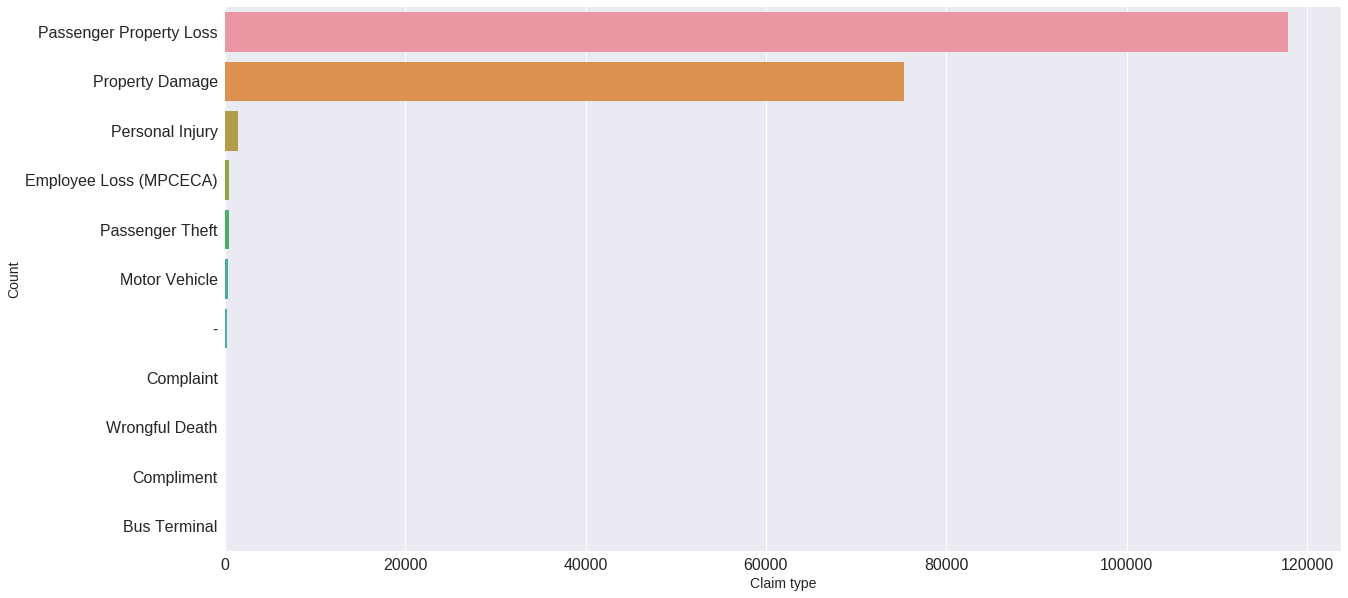

In [8]:
# Let's visualize these claims along with the numbers they have been reported
claim_index = unique_claim_type.index
claim_values = unique_claim_type.values

plt.figure(figsize=(20,10))
sns.barplot(y=claim_index, x=claim_values, orient='horizontal')
plt.xlabel('Claim type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

So, property loss is the most common type of thing that happens on the airport. I don't get it how but it seems that there are too many propoerty damage cases too. 

In [9]:
# Let's move to the claim site
unique_claim_sites = data['Claim Site'].value_counts()
print("Total number of unique claim sites : ", len(unique_claim_sites))

Total number of unique claim sites :  6


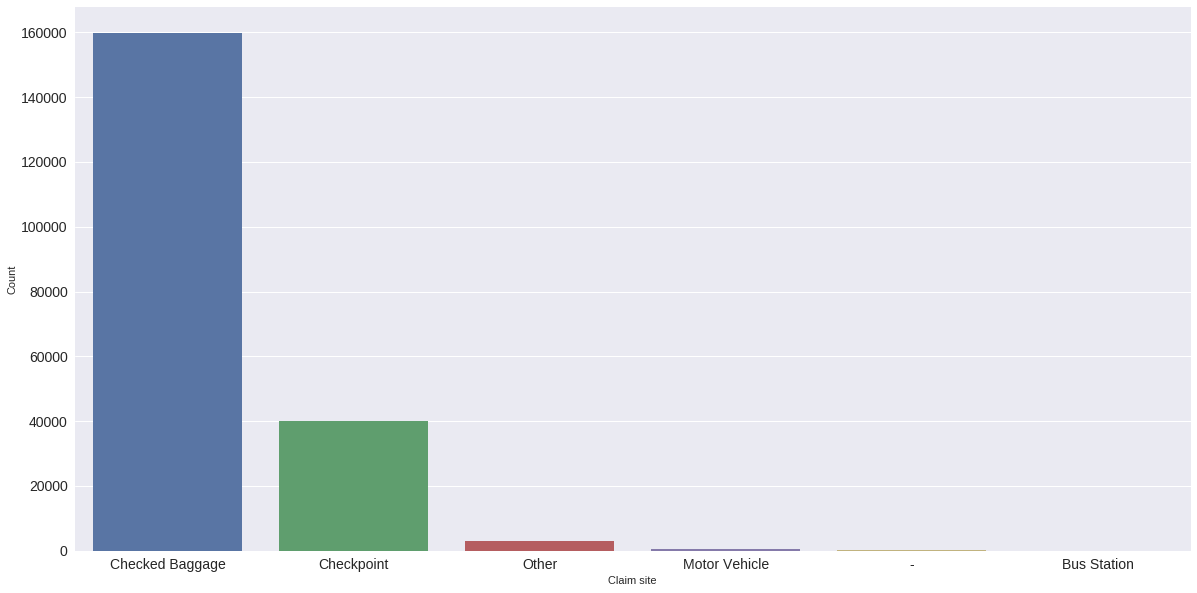

In [10]:
# Let's visualize the actual number of instances for each class of claim site
x = unique_claim_sites.index
y = unique_claim_sites.values

f = plt.figure(figsize=(20,10))
sns.barplot(x, y)
plt.xlabel('Claim site')
plt.ylabel('Count')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

So checked baggage and checkpoint are the sites where maximum incidents happen

In [11]:
# Let's move to the date columns for now. There are too many null values. Converting the column to datetime without
# removing them may produce undesirable results. Will be happy to see some good
# solution to it
data['Date Received'] = pd.to_datetime(data['Date Received'])
data['Received day'] = data['Date Received'].dt.weekday
data['Received month'] = data['Date Received'].dt.month

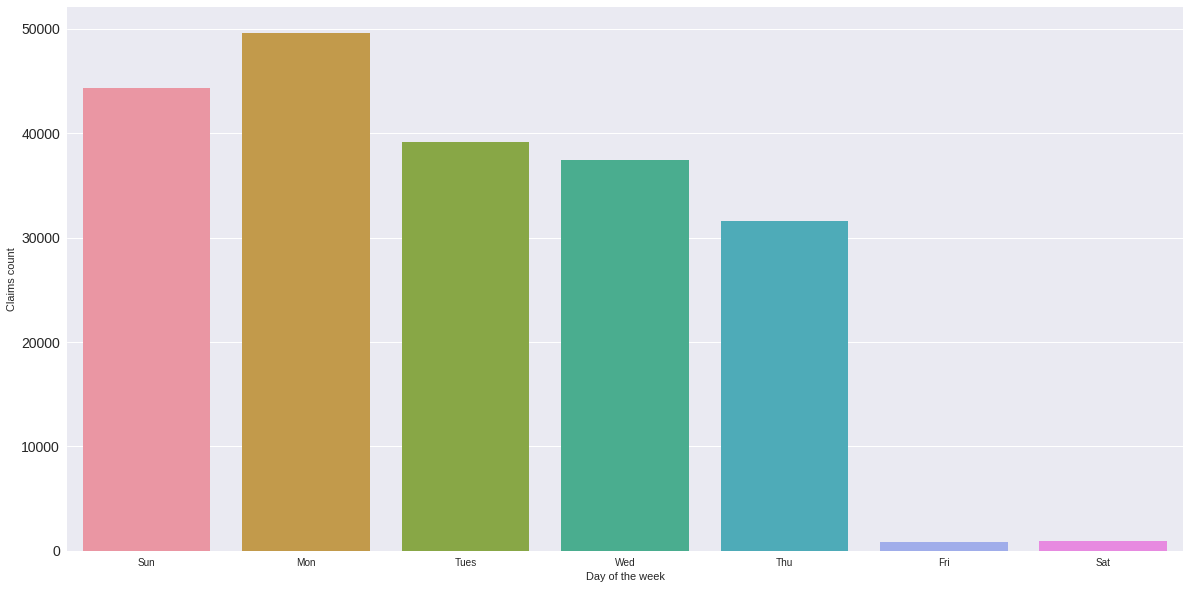

In [12]:
# Check the number of claims on different days
claims_count = data['Received day'].value_counts()

plt.figure(figsize=(20,10))
sns.barplot(claims_count.index, claims_count.values)
plt.xlabel('Day of the week')
plt.ylabel('Claims count')
plt.xticks(range(7), ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.yticks(fontsize=14)
plt.show()

so, maximum claims happens to be on Monday followed by Sunday and Tuesday. Why is it so? Remeber the number of claims regarding property loss? Maybe because people travel on weekens a lot.

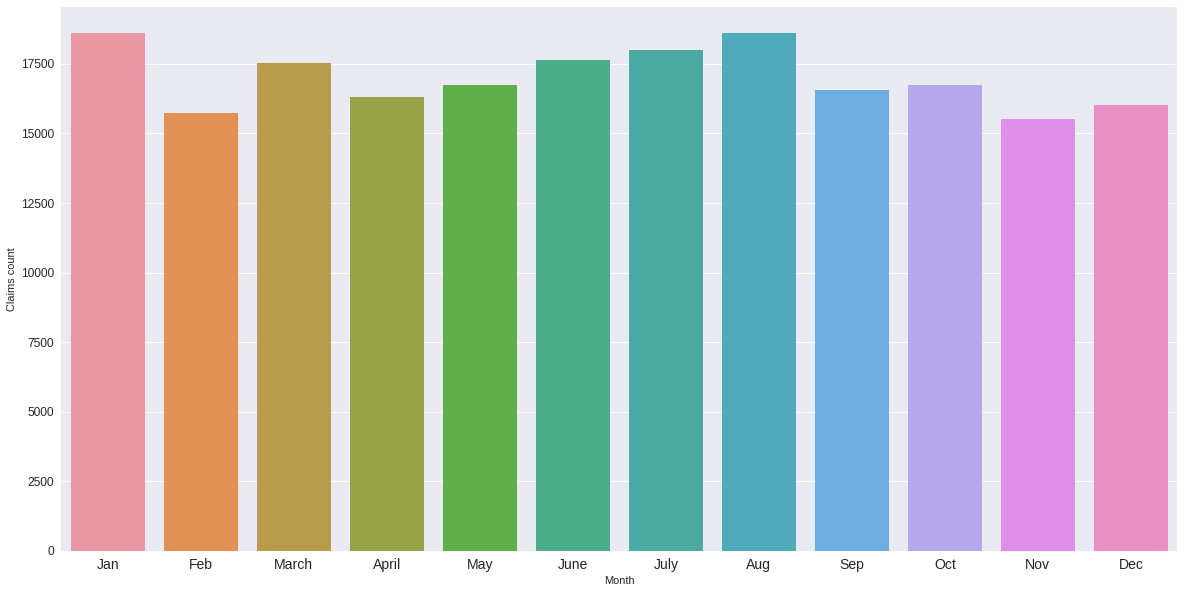

In [13]:
claims_count = data['Received month'].value_counts()
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(20,10))
sns.barplot(claims_count.index, claims_count.values)
plt.xlabel('Month')
plt.ylabel('Claims count')
plt.xticks(range(12), months, fontsize=14)
plt.yticks(fontsize=12)
plt.show()

So January and August are the months where maximum number of claim reports are received

The date columns are so much messed up. There is so much of noise that I can't think of something good right now to filter them. Let's move to the next feature

In [14]:
def split_amount(x):
    try:
        if x is not None:
            a = x.split('$')[1]
            if ';' in a:
                b,c = a.split(';')
                return eval(b + c)
            return eval(a)
    except:
        return 0

In [15]:
data['Claim Amount'] = data['Claim Amount'].apply(split_amount)
print("Maximum amount claimed : ", data['Claim Amount'].max())
print("Average amount claimed : ", data['Claim Amount'].mean())

Maximum amount claimed :  951200.0
Average amount claimed :  664.1886971463506


In [16]:
data['Close Amount'] = data['Close Amount'].apply(split_amount)
print("Maximum closed amount  : ", data['Close Amount'].max())
print("Average closed amount  : ", data['Close Amount'].mean())

Maximum closed amount  :  250000.0
Average closed amount  :  65.11366745485391


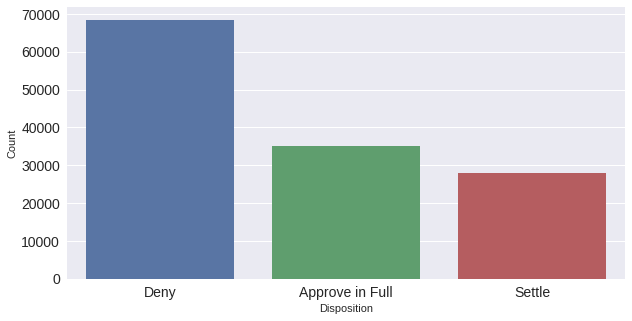

In [17]:
# Let's move to the disposition column finally
dispos = data['Disposition'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(dispos.index, dispos.values)
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

That's it for now. The data contains too much of noise which requires some time to come up with some good techniques to filter that. Will get back to it later. Please upvote if you find this kernel useful.